In [1]:
import math
import time

from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta

from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

from pprint import pprint

2025-06-28 19:06:01.749902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751137562.041675      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751137562.131161      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## dataset load

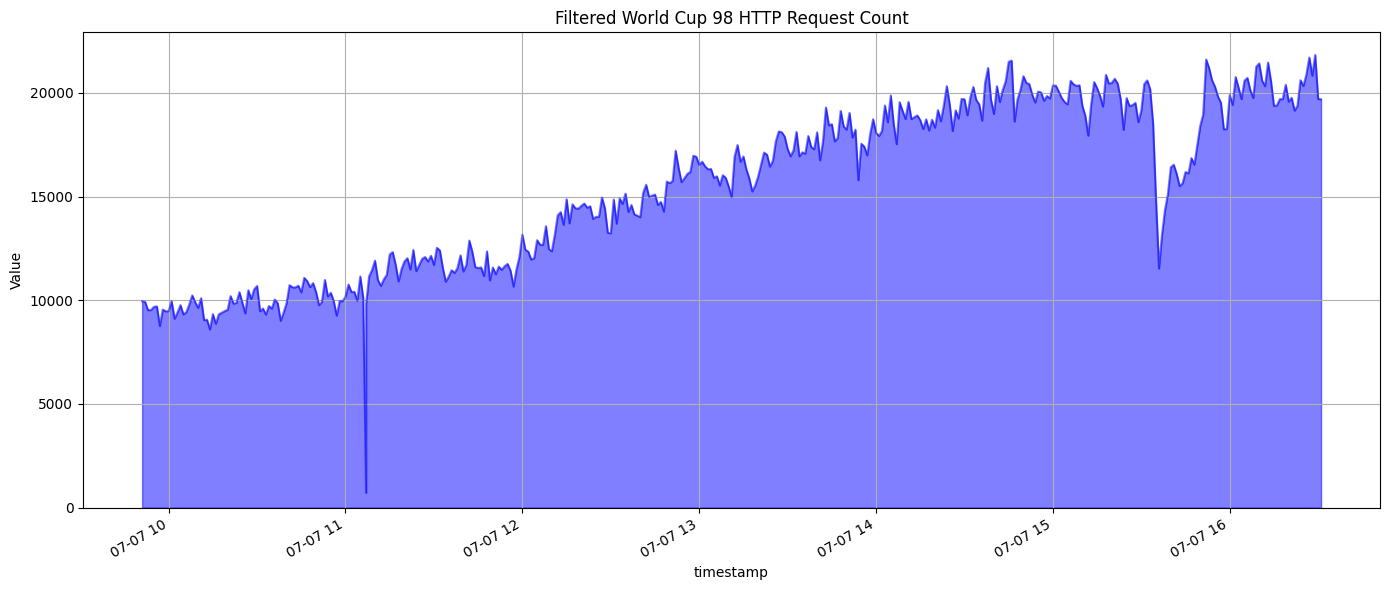

In [2]:
wcdf = pd.read_csv('/kaggle/input/fifa-wc98/merged_data.csv',
                   usecols=["timestamp", "value"],
                   index_col=["timestamp"],
                   parse_dates=["timestamp"]
                  ).sort_index()


df_filtered = wcdf.loc['1998-07-07 09:51:00':'1998-07-07 16:31:00']

plt.figure(figsize=(14, 6))

df_filtered['value'].plot(kind='area', color='blue', alpha=0.5)

plt.title('Filtered World Cup 98 HTTP Request Count')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

## helper

### model handler class

In [3]:
# check model handler and implementation

class ModelHandler:
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.model = None
        
        self.sequence_length = 10
        self.input_shape = (1, 10, 1)

        self._load_model()
    
    def _load_model(self):
        self.model = tf.saved_model.load(self.model_path)
        
        self.serving_fn = self.model.signatures['serving_default']
        
        return True

    def _preprocess_data(self, historical_data: List, scaler: TransformerMixin):
        data_array = np.array(historical_data)
        
        scaled_data_array = scaler.fit_transform(data_array)

        reshaped_data = scaled_data_array.reshape(self.input_shape)
        
        return reshaped_data

    def _predict_raw(self, input_data: np.ndarray):
        input_tensor = tf.constant(input_data, dtype=tf.float32)
        
        input_keys = list(self.serving_fn.structured_input_signature[1].keys())
        if not input_keys:
            return None
        
        input_key = input_keys[0]
        
        prediction = self.serving_fn(**{input_key: input_tensor})
        
        output_keys = list(prediction.keys())
        if not output_keys:
            return None
        
        output_key = output_keys[0]
        pred_value = prediction[output_key].numpy()
        
        return pred_value
    
    def predict(self, historical_data: List, scaler: TransformerMixin):

        processed_data = self._preprocess_data(historical_data, scaler)
        if processed_data is None:
            return None
        
        prediction = self._predict_raw(processed_data)

        scaled_prediction = scaler.inverse_transform(prediction)[0][0]

        return scaled_prediction

### kubernetes default HPA algorithm class

In [4]:
class HpaHttpScaler:
    def __init__(self, target_requests_per_pod: int, target_utilization_percentage: int = 70):
        self.target_requests_per_pod = target_requests_per_pod
        self.target_utilization_percentage = target_utilization_percentage
        
        # Calculate the actual target based on percentage
        self.effective_target = (target_requests_per_pod * target_utilization_percentage) / 100

        self.scale_up_cooldown: timedelta = timedelta(minutes=3)
        self.scale_down_cooldown: timedelta = timedelta(minutes=5)
        self.tolerance = 0.1  # 10% tolerance to prevent flapping
        
        current_time = datetime.now()
        self.last_scale_up_time: datetime = current_time - self.scale_up_cooldown
        self.last_scale_down_time: datetime = current_time - self.scale_down_cooldown
    
    def get_desired_replicas(
        self, 
        current_replicas: int, 
        current_requests: int,
        current_time: datetime = None
    ):
        if current_time is None:
            current_time = datetime.now()
        
        # Handle edge cases
        if current_replicas <= 0:
            return 1
        
        if self.effective_target <= 0:
            return current_replicas
        
        # Handle zero requests
        if current_requests == 0:
            return current_replicas  # Don't scale down immediately on zero requests
        
        # Calculate current requests per pod
        current_requests_per_pod = current_requests / current_replicas
        
        # Apply HPA formula using effective target (not the full capacity)
        utilization_ratio = current_requests_per_pod / self.effective_target
        
        # Apply tolerance - don't scale for small changes
        if abs(utilization_ratio - 1.0) < self.tolerance:
            return current_replicas
        
        raw_desired_replicas = max(1, math.ceil(current_replicas * utilization_ratio))
        
        # Determine if scaling up or down
        scaling_up = raw_desired_replicas > current_replicas
        scaling_down = raw_desired_replicas < current_replicas
        
        # Check cooldown periods - return early if in cooldown
        if scaling_up:
            time_since_scale_up = current_time - self.last_scale_up_time
            if time_since_scale_up < self.scale_up_cooldown:
                return current_replicas
                    
        if scaling_down:
            time_since_scale_down = current_time - self.last_scale_down_time
            if time_since_scale_down < self.scale_down_cooldown:
                return current_replicas
        
        # Apply rate limiting and update timestamps only when actually scaling
        if scaling_up:
            max_scale_up = math.ceil(current_replicas * 2)
            desired_replicas = min(raw_desired_replicas, max_scale_up)
            
            if desired_replicas > current_replicas:  # Actual scaling will occur
                self.last_scale_up_time = current_time
            else:
                desired_replicas = current_replicas  # No scaling after rate limiting
                
        elif scaling_down:
            min_scale_down = max(1, math.ceil(current_replicas * 0.5))
            desired_replicas = max(raw_desired_replicas, min_scale_down)
            
            if desired_replicas < current_replicas:  # Actual scaling will occur
                self.last_scale_down_time = current_time
            else:
                desired_replicas = current_replicas  # No scaling after rate limiting
        else:
            desired_replicas = current_replicas
        
        return desired_replicas

### ai scaling algorithm class

In [5]:
@dataclass
class ScalingConfig:
    min_replicas: int
    max_replicas: int
    workload_per_pod: int
    resource_removal_strategy: float

class CustomScaling:
    def __init__(self):
        self.last_scaling_time: datetime = datetime.now() - timedelta(seconds=60)
    
    def _calculate_required_pods(self, predicted_workload: float, workload_per_pod: int):
        if workload_per_pod <= 0:
            return 1
            
        required_pods = math.ceil(predicted_workload / workload_per_pod)
        
        return max(1, required_pods)
    
    def _is_in_cooldown(self, current_time):
        last_scaling = self.last_scaling_time
        cooldown_end = last_scaling + timedelta(seconds=60)
        
        return current_time < cooldown_end
    
    def _get_cooldown_remaining(self, current_time):
        last_scaling = self.last_scaling_time
        cooldown_end = last_scaling + timedelta(seconds=60)
        remaining = cooldown_end - current_time
        
        return max(0, int(remaining.total_seconds()))
    
    def calculate_scaling_decision(
        self, 
        predicted_workload: float, 
        current_replicas: int, 
        config: ScalingConfig,
        current_time: datetime = None
    ):
        # Check if we're in cooldown period
        if self._is_in_cooldown(current_time):
            return current_replicas
        
        pods_required = self._calculate_required_pods(predicted_workload, config.workload_per_pod)
        
        # Determine if scaling action is needed
        scaling_needed = pods_required != current_replicas
        
        if pods_required > current_replicas:
            # Scale out scenario
            target_replicas = min(pods_required, config.max_replicas)
            
        elif pods_required < current_replicas:
            # Scale in scenario with RRS
            # Step 1: Ensure we don't go below minimum
            pods_adjusted = max(pods_required, config.min_replicas)
            
            # Step 2: Calculate how many pods to remove using RRS
            pods_to_remove = current_replicas - pods_adjusted
            pods_to_actually_remove = math.floor(pods_to_remove * config.resource_removal_strategy)
            
            # Step 3: Calculate final target replicas
            target_replicas = current_replicas - pods_to_actually_remove
            
            # Ensure we don't go below minimum
            target_replicas = max(target_replicas, config.min_replicas)
            
        else:
            # No scaling needed
            target_replicas = current_replicas
        
        # Update timestamp only if:
        # 1. Scaling was needed based on workload, AND
        # 2. We're actually changing the replica count (not blocked by constraints)
        if scaling_needed and target_replicas != current_replicas:
            self.last_scaling_time = current_time
        
        return target_replicas

### get request and pods data function

In [6]:
def process_autoscaler_data(
    filtered_data: pd.DataFrame, 
    scaler: TransformerMixin, 
    model_handler_instance: ModelHandler,
    default_autoscaler_instance: HpaHttpScaler,
    ai_autoscaler_instance: CustomScaling,
    config: ScalingConfig,
    initial_replicas: int,
    start_time: datetime = None
    ):
    
    required_columns = ['value']
    missing_columns = [col for col in required_columns if col not in filtered_data.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    min_required_rows = 10  # Need 10 points for AI model
    if len(filtered_data) < min_required_rows:
        raise ValueError(f"Need at least {min_required_rows} rows, got {len(filtered_data)}")
    
    request_list = []
    ai_pods_list = []
    default_pods_list = []
    
    window_size = 10
    start_index = window_size - 1  # Start at index 9 (0-based)
    iterator = range(start_index, len(filtered_data))

    # Initialize replicas and time
    current_default_replicas = initial_replicas
    current_ai_replicas = initial_replicas
    
    # Use provided start time or current time
    if start_time is None:
        start_time = datetime.now()
    current_time = start_time

    for i in iterator:
        # Process request data
        current_request = filtered_data.iloc[i]['value']
        request_list.append(current_request)

        # Process default autoscaler
        result_hpa_replicas = default_autoscaler_instance.get_desired_replicas(
            current_replicas=current_default_replicas, 
            current_requests=current_request,
            current_time=current_time
        )
        current_default_replicas = result_hpa_replicas
        default_pods_list.append(result_hpa_replicas)

        # Process AI autoscaler
        ai_input_start = i - window_size + 1
        ai_input_data = filtered_data.iloc[ai_input_start:i+1][['value']].values
        
        prediction_result = model_handler_instance.predict(ai_input_data, scaler)
        
        result_ai_scaling = ai_autoscaler_instance.calculate_scaling_decision(
            predicted_workload=prediction_result, 
            current_replicas=current_ai_replicas,
            config=config,
            current_time=current_time
        )
        
        current_ai_replicas = result_ai_scaling
        ai_pods_list.append(result_ai_scaling)

        # Increment time (representing time between data points)
        current_time = current_time + timedelta(minutes=1)
    
    # Final validation
    if len(request_list) != len(ai_pods_list) or len(request_list) != len(default_pods_list):
        raise Exception("Output lists are not synchronized")
    
    return request_list, ai_pods_list, default_pods_list

### autoscaler metrics evaluator class

In [7]:
class AutoscalerEvaluator:
    """
    Evaluates autoscaler performance using metrics from research paper:
    - ΘU[%]: Under-provisioning metric
    - ΘO[%]: Over-provisioning metric  
    - TU[%]: Time duration under-provisioned
    - TO[%]: Time duration over-provisioned
    - εn: Elastic speedup (autoscaling gain vs no autoscaling)
    """
    
    def __init__(self, workload_per_pod: int, initial_replicas: int):
        self.workload_per_pod = workload_per_pod
        self.initial_replicas = initial_replicas
        
    def _calculate_required_pods(self, requests: List[int]):
        """Calculate required pods with proper validation."""
        if not requests:
            return []
        
        # Validate input
        if any(req < 0 for req in requests):
            raise ValueError("Request values cannot be negative")
            
        return [max(1, math.ceil(req / self.workload_per_pod)) for req in requests]
    
    def _validate_inputs(self, required_pods: List[int], provisioned_pods: List[int]):
        """Common input validation for metric calculations."""
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        if not required_pods:
            raise ValueError("Input lists cannot be empty")
            
        if any(p < 0 for p in required_pods + provisioned_pods):
            raise ValueError("Pod counts cannot be negative")
    
    def _calculate_theta_u(self, required_pods: List[int], provisioned_pods: List[int], delta_t: float = 1.0):
        """
        Calculate under-provisioning metric ΘU[%].
        ΘU[%] = (100/T) * Σ(max(rt - pt, 0)/rt) * Δt
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        theta_u_sum = 0.0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:  # Avoid division by zero
                theta_u_sum += (max(rt - pt, 0) / rt) * delta_t
        
        return (100.0 / T) * theta_u_sum
    
    def _calculate_theta_o(self, required_pods: List[int], provisioned_pods: List[int], delta_t: float = 1.0):
        """
        Calculate over-provisioning metric ΘO[%].
        ΘO[%] = (100/T) * Σ(max(pt - rt, 0)/rt) * Δt
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        theta_o_sum = 0.0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:  # Avoid division by zero
                theta_o_sum += (max(pt - rt, 0) / rt) * delta_t
        
        return (100.0 / T) * theta_o_sum
    
    def _calculate_t_u(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration under-provisioned TU[%].
        TU[%] = (100/T) * Σ max(sgn(rt - pt), 0) * Δt
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        under_provisioned_count = 0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > pt:  # sgn(rt - pt) > 0
                under_provisioned_count += 1
        
        return (100.0 / T) * under_provisioned_count
    
    def _calculate_t_o(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration over-provisioned TO[%].
        TO[%] = (100/T) * Σ max(sgn(pt - rt), 0) * Δt
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        over_provisioned_count = 0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if pt > rt:  # sgn(pt - rt) > 0
                over_provisioned_count += 1
        
        return (100.0 / T) * over_provisioned_count
    
    def _calculate_elastic_speedup(self, 
                                ai_metrics: Dict[str, float], 
                                default_metrics: Dict[str, float]):
        """
        Calculate elastic speedup εn to compare AI vs Default autoscaler:
        εn = (Θᵤ,default × Θₒ,default × Tᵤ,default × Tₒ,default / Θᵤ,ai × Θₒ,ai × Tᵤ,ai × Tₒ,ai)^(1/4)
        
        εn > 1 means AI autoscaler performs better than default autoscaler.
        """
        # Extract metrics for readability
        default_theta_u = default_metrics['theta_u']
        default_theta_o = default_metrics['theta_o'] 
        default_t_u = default_metrics['t_u']
        default_t_o = default_metrics['t_o']
        
        ai_theta_u = ai_metrics['theta_u']
        ai_theta_o = ai_metrics['theta_o']
        ai_t_u = ai_metrics['t_u'] 
        ai_t_o = ai_metrics['t_o']
        
        # Handle zero values by adding small epsilon to avoid division by zero
        # This is necessary because any zero metric makes the product zero
        epsilon = 1e-10
        
        # Calculate products with epsilon adjustment
        default_product = max(epsilon, default_theta_u * default_theta_o * default_t_u * default_t_o)
        ai_product = max(epsilon, ai_theta_u * ai_theta_o * ai_t_u * ai_t_o)
        
        # Calculate elastic speedup with 4th root
        # Higher default product / lower AI product = better AI performance
        epsilon_n = (default_product / ai_product) ** (1/4)
        
        return epsilon_n
    

    
    def _calculate_efficiency_score(self, metrics: Dict[str, float]):
        """Calculate a single efficiency score from all metrics."""
        # Perfect efficiency = 0 (no over/under provisioning)
        # Weights: under-provisioning is worse than over-provisioning
        weights = {'theta_u': 2.0, 'theta_o': 1.0, 't_u': 1.5, 't_o': 0.5}
        total_weight = sum(weights.values())
        
        weighted_score = sum(metrics[metric] * weight 
                           for metric, weight in weights.items()) / total_weight
        
        return weighted_score
    
    def evaluate_autoscaler(self, 
                          requests: List[int], 
                          provisioned_pods: List[int],
                          autoscaler_name: str,
                          delta_t: float = 1.0):
        """Evaluate a single autoscaler's performance."""
        if not requests or not provisioned_pods:
            raise ValueError("Input lists cannot be empty")
            
        required_pods = self._calculate_required_pods(requests)
        
        metrics = {
            'theta_u': self._calculate_theta_u(required_pods, provisioned_pods, delta_t),
            'theta_o': self._calculate_theta_o(required_pods, provisioned_pods, delta_t),
            't_u': self._calculate_t_u(required_pods, provisioned_pods),
            't_o': self._calculate_t_o(required_pods, provisioned_pods)
        }
        
        return metrics
    
    def compare_autoscalers(self,
                          requests: List[int],
                          ai_provisioned_pods: List[int],
                          default_provisioned_pods: List[int],
                          start_time: Optional[datetime] = None,
                          end_time: Optional[datetime] = None,
                          delta_t: float = 1.0):
        """Compare AI autoscaler vs Default autoscaler performance."""
        # Evaluate AI autoscaler
        ai_metrics = self.evaluate_autoscaler(requests, ai_provisioned_pods, "AI Autoscaler", delta_t)
        
        # Evaluate default autoscaler
        default_metrics = self.evaluate_autoscaler(requests, default_provisioned_pods, "Default Autoscaler", delta_t)
        
        # Calculate elastic speedup (AI vs Default)
        elastic_speedup = self._calculate_elastic_speedup(ai_metrics, default_metrics)
        
        # Create comparison summary
        comparison = {
            'ai_metrics': ai_metrics,
            'default_metrics': default_metrics,
            'elastic_speedup': elastic_speedup,
            'performance_summary': {
                'theta_u_improvement': default_metrics['theta_u'] - ai_metrics['theta_u'],
                'theta_o_improvement': default_metrics['theta_o'] - ai_metrics['theta_o'],
                't_u_improvement': default_metrics['t_u'] - ai_metrics['t_u'],
                't_o_improvement': default_metrics['t_o'] - ai_metrics['t_o'],
                'ai_better_overall': elastic_speedup > 1.0
            }
        }
        
        return comparison
    
    def _plot_provisioned_pods(self,
                              requests: List[int],
                              ai_provisioned_pods: List[int],
                              default_provisioned_pods: List[int],
                              timestamps: Optional[List[datetime]]=None):
        """Plot the provisioned pods vs required pods over time."""
        required_pods = self._calculate_required_pods(requests)
    
        all_pod_data = ai_provisioned_pods + default_provisioned_pods + required_pods
        max_pods = max(all_pod_data)
        
        if timestamps is None:
            timestamps = list(range(len(requests)))
    
        fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

        ax1.set_ylim(0, max_pods + 1)

        # Plot required pods first (as baseline)
        ax1.plot(timestamps, required_pods, label='Required Pods', 
                 color='green', linestyle='--', linewidth=3, alpha=0.9)
        ax1.plot(timestamps, ai_provisioned_pods, label='AI Provisioned', 
                 color='red', linewidth=2, marker='o', markersize=4)
        ax1.plot(timestamps, default_provisioned_pods, label='Default Provisioned', 
                 color='blue', linewidth=2, marker='s', markersize=4)
    
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Number of Pods', color='black')
        ax1.grid(True, alpha=0.3)
    
        ax1.legend(loc='upper left')
        
        ax1.set_title('Pod Allocation Over Time', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def _plot_provisioning_errors_combined(self,
                                         requests: List[int],
                                         ai_provisioned_pods: List[int],
                                         default_provisioned_pods: List[int],
                                         timestamps: Optional[List[datetime]]=None):
        """Plot combined over/under provisioning comparison (original approach but improved)."""
        required_pods = self._calculate_required_pods(requests)
        
        if timestamps is None:
            timestamps = list(range(len(requests)))
    
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        
        # Calculate errors as differences (positive = over, negative = under)
        ai_errors = [ai - req for ai, req in zip(ai_provisioned_pods, required_pods)]
        default_errors = [def_p - req for def_p, req in zip(default_provisioned_pods, required_pods)]
    
        # Plot as lines with different styles for positive and negative
        ax.plot(timestamps, ai_errors, color='red', linewidth=2, marker='o', markersize=4, 
                label='AI Autoscaler Error', alpha=0.8)
        ax.plot(timestamps, default_errors, color='blue', linewidth=2, marker='s', markersize=4,
                label='Default Autoscaler Error', alpha=0.8)
        
        # Add horizontal reference line
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect provisioning')
        
        # Add shaded regions to show over/under provisioning zones
        ax.axhspan(0, ax.get_ylim()[1], alpha=0.1, color='red', label='Over-provisioning zone')
        ax.axhspan(ax.get_ylim()[0], 0, alpha=0.1, color='orange', label='Under-provisioning zone')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Provisioning Error (Pods)')
        ax.legend()
        ax.set_title('Provisioning Error Comparison (Positive=Over, Negative=Under)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparison(self,
                       requests: List[int],
                       ai_provisioned_pods: List[int],
                       default_provisioned_pods: List[int],
                       timestamps: Optional[List[datetime]]=None):
        """Plot comprehensive comparison of autoscaler performance."""
        self._plot_provisioned_pods(requests, ai_provisioned_pods, default_provisioned_pods, timestamps)
        self._plot_provisioning_errors_combined(requests, ai_provisioned_pods, default_provisioned_pods, timestamps)
        
        # Also show metrics summary
        comparison_results = self.compare_autoscalers(requests, ai_provisioned_pods, default_provisioned_pods)
        
        print("\n=== AUTOSCALER PERFORMANCE COMPARISON ===")
        print(f"AI Autoscaler Metrics:")
        for metric, value in comparison_results['ai_metrics'].items():
            print(f"  {metric.upper()}: {value:.2f}%")
            
        print(f"\nDefault Autoscaler Metrics:")
        for metric, value in comparison_results['default_metrics'].items():
            print(f"  {metric.upper()}: {value:.2f}%")
            
        print(f"\nElastic Speedup: {comparison_results['elastic_speedup']:.3f}")

## get autoscaler data

### intial config

In [8]:
df_scaler = MinMaxScaler(feature_range=(-1,1))


workload_per_pod = 5000
initial_replicas = 2

timestamps = df_filtered.index[9:].to_pydatetime().tolist()

### bilstm DQ predictor model

In [9]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BilstmDq = ModelHandler('/kaggle/input/bi-lstm/tensorflow2/default/2/bilstm_dq')

data_evaluation_BilstmDq = process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BilstmDq,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

2025-06-28 19:06:22.237768: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### bilstm MD predictor model

In [10]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BilstmMd = ModelHandler('/kaggle/input/bi-lstm/tensorflow2/default/2/bilstm_md')

data_evaluation_BilstmMd= process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BilstmMd,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

### bayesian bilstm predictor model

In [11]:
hpa_autoscaler = HpaHttpScaler(
    target_requests_per_pod=workload_per_pod
    )

ai_autoscaler = CustomScaling()

ai_autoscaler_config = ScalingConfig(
    min_replicas=2,
    max_replicas=25,
    workload_per_pod=workload_per_pod,
    resource_removal_strategy=0.6
)

model_BoBilstm = ModelHandler('/kaggle/input/bi-lstm/tensorflow2/default/2/bilstm_bo_opt')


data_evaluation_BoBilstm = process_autoscaler_data(
    filtered_data=df_filtered, 
    scaler=df_scaler, 
    model_handler_instance=model_BoBilstm,
    default_autoscaler_instance=hpa_autoscaler,
    ai_autoscaler_instance=ai_autoscaler,
    config=ai_autoscaler_config,
    initial_replicas=initial_replicas
    )

## autoscaler evaluation

### bilstm DQ predictor model

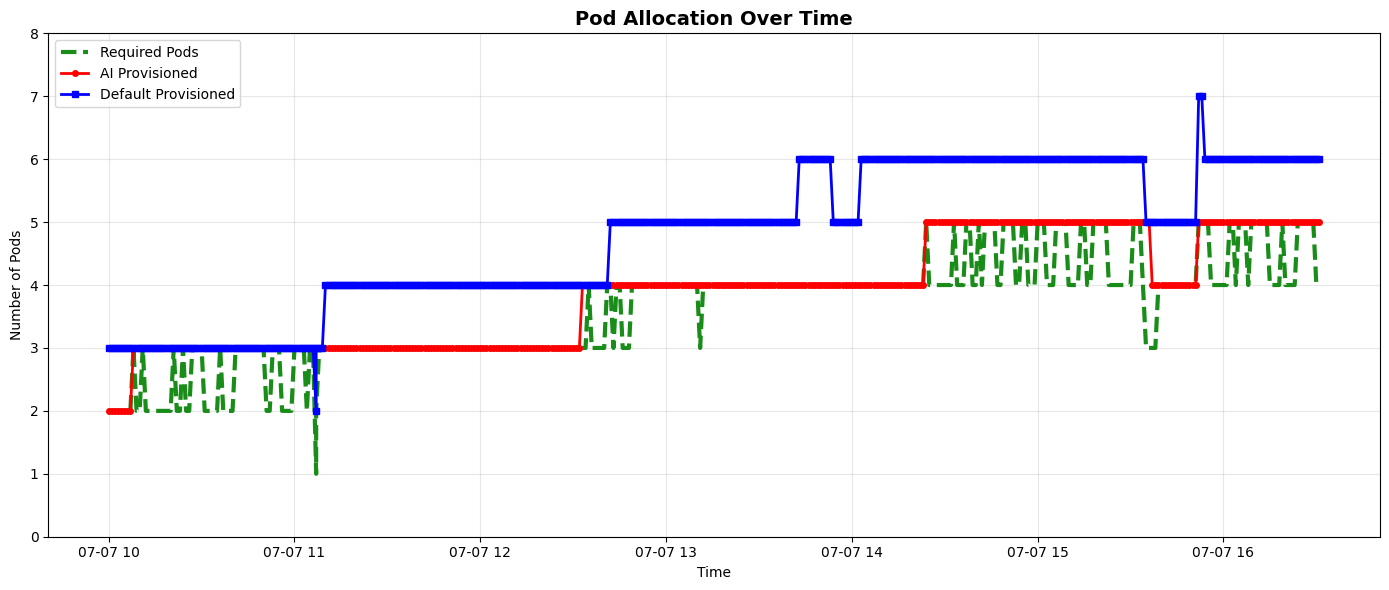

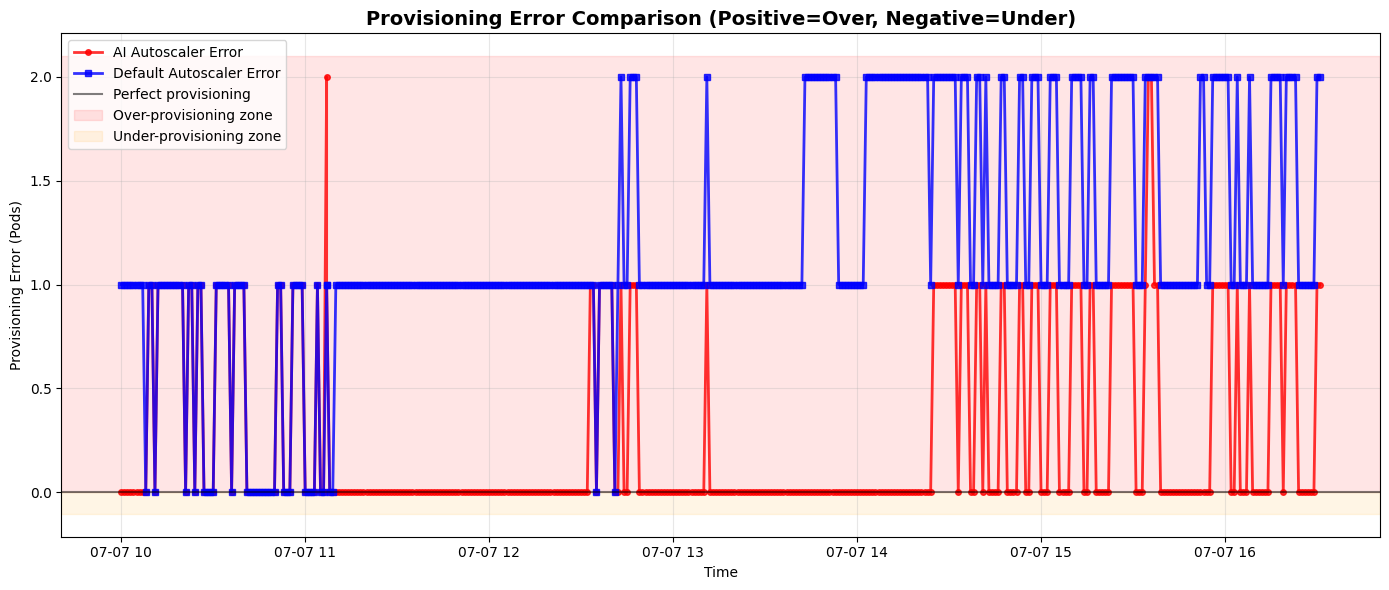


=== AUTOSCALER PERFORMANCE COMPARISON ===
AI Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 9.73%
  T_U: 0.00%
  T_O: 26.97%

Default Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 33.64%
  T_U: 0.00%
  T_O: 91.86%

Elastic Speedup: 1.000


In [12]:
requests_data = data_evaluation_BilstmDq[0]
ai_provisioned_data = data_evaluation_BilstmDq[1]
default_provisioned_data = data_evaluation_BilstmDq[2]

evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

evaluator.plot_comparison(
    requests=requests_data,
    ai_provisioned_pods=ai_provisioned_data,
    default_provisioned_pods=default_provisioned_data,
    timestamps=timestamps
)

### bilstm MD predictor model

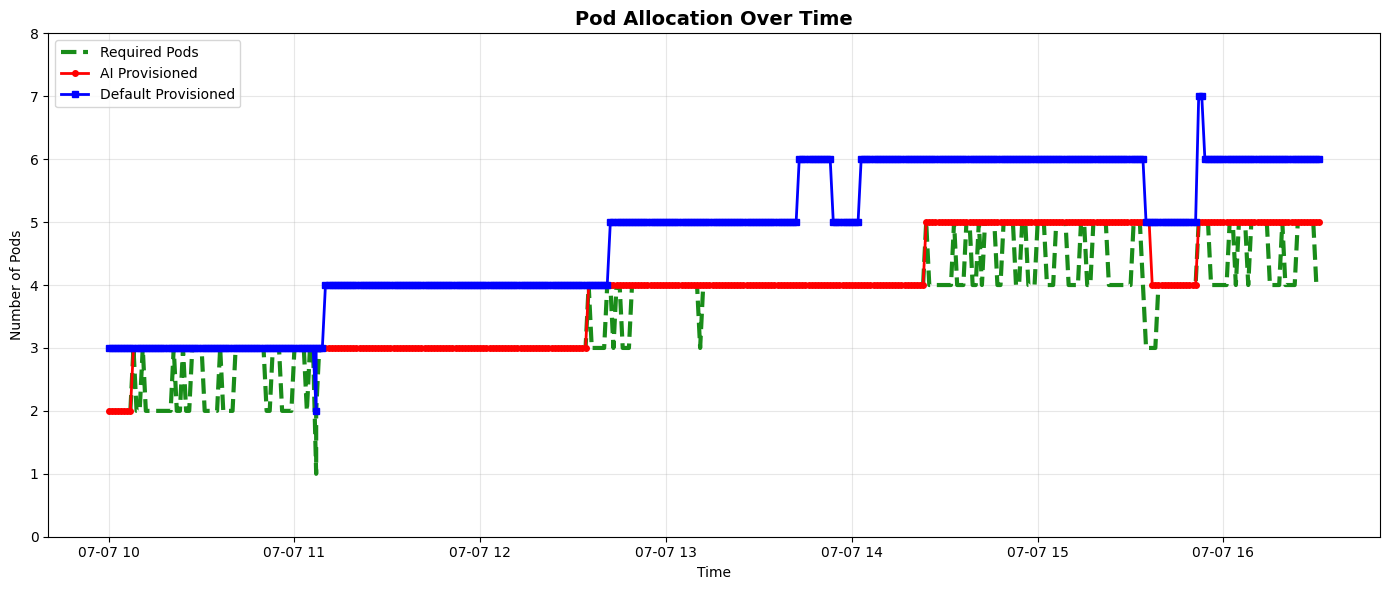

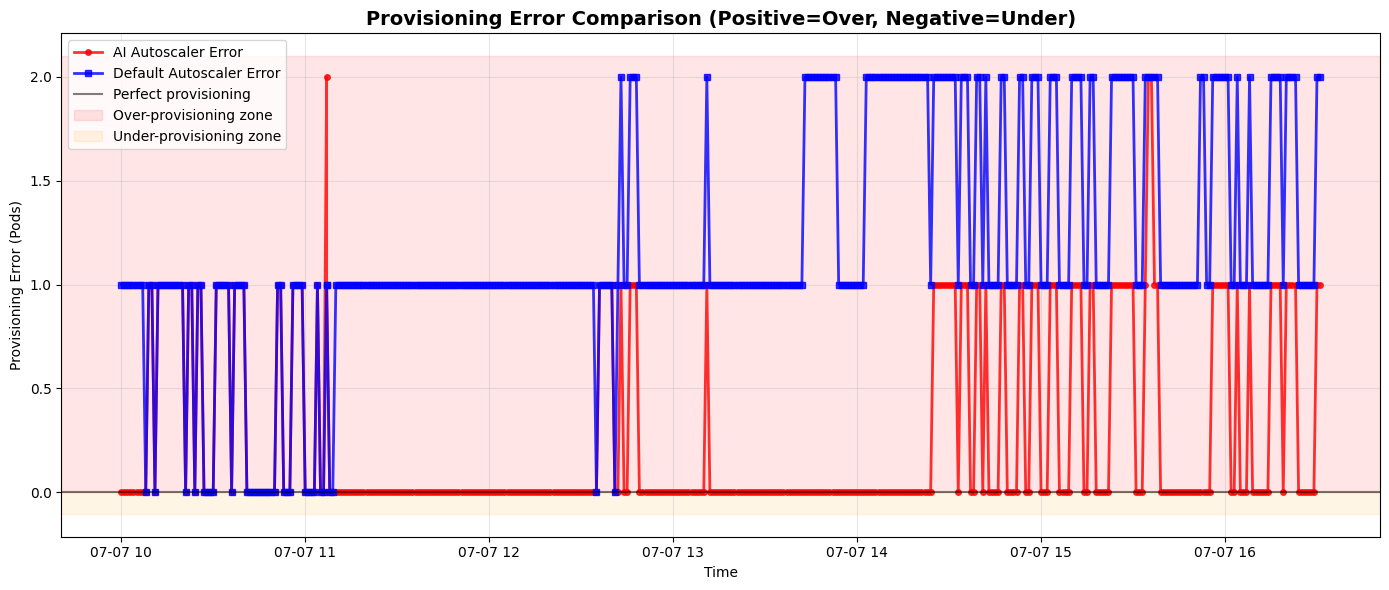


=== AUTOSCALER PERFORMANCE COMPARISON ===
AI Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 9.56%
  T_U: 0.00%
  T_O: 26.46%

Default Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 33.64%
  T_U: 0.00%
  T_O: 91.86%

Elastic Speedup: 1.000


In [13]:
requests_data = data_evaluation_BilstmMd[0]
ai_provisioned_data = data_evaluation_BilstmMd[1]
default_provisioned_data = data_evaluation_BilstmMd[2]

evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

evaluator.plot_comparison(
    requests=requests_data,
    ai_provisioned_pods=ai_provisioned_data,
    default_provisioned_pods=default_provisioned_data,
    timestamps=timestamps
)

### bayesian bilstm predictor model

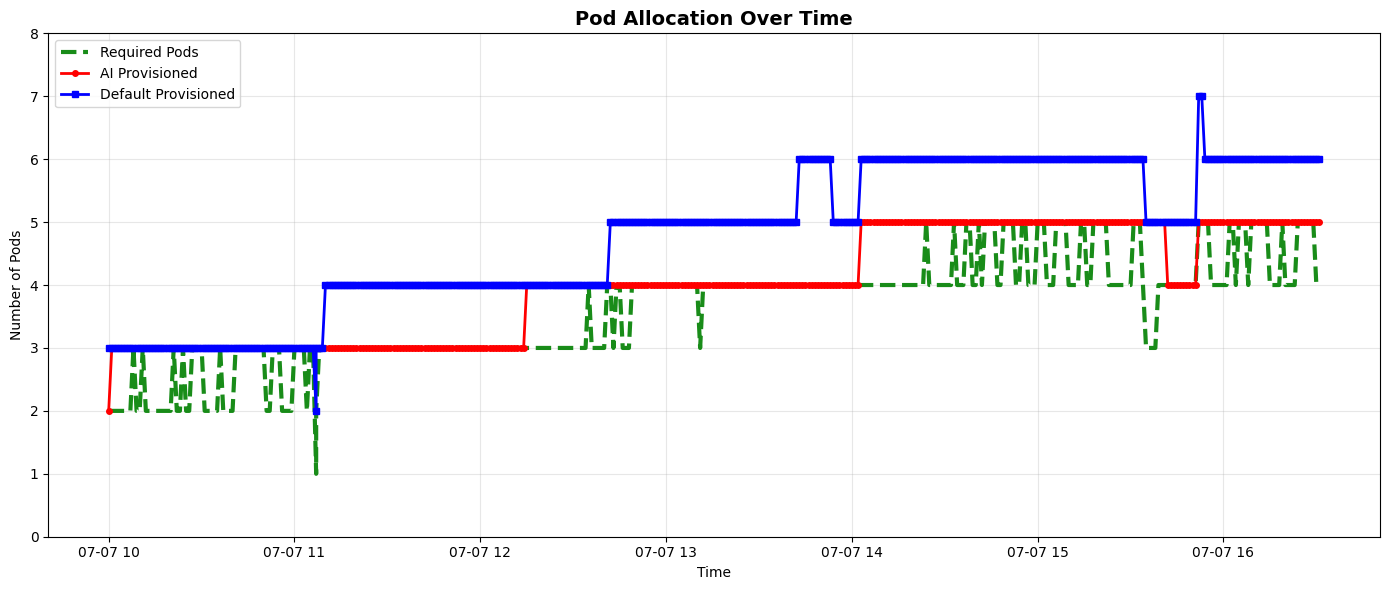

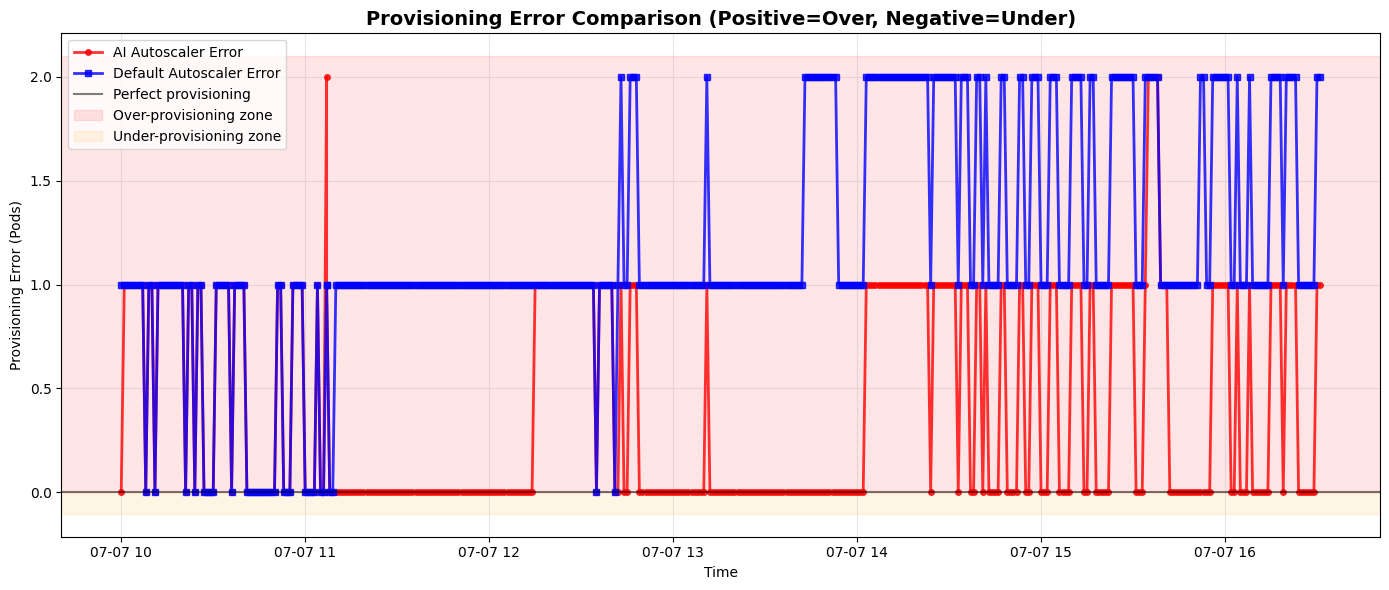


=== AUTOSCALER PERFORMANCE COMPARISON ===
AI Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 13.85%
  T_U: 0.00%
  T_O: 39.44%

Default Autoscaler Metrics:
  THETA_U: 0.00%
  THETA_O: 33.64%
  T_U: 0.00%
  T_O: 91.86%

Elastic Speedup: 1.000


In [14]:
requests_data = data_evaluation_BoBilstm[0]
ai_provisioned_data = data_evaluation_BoBilstm[1]
default_provisioned_data = data_evaluation_BoBilstm[2]

evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

evaluator.plot_comparison(
    requests=requests_data,
    ai_provisioned_pods=ai_provisioned_data,
    default_provisioned_pods=default_provisioned_data,
    timestamps=timestamps
)